# Projection Orthogonal Complement Classifier

In this notebook, we show how to use the Projection onto the Orthogonal Complement pipeline to classify handritten digits, both in the pixel and scattering domain.
Furthermore, we use a validation approach in order to optimize the model hyperparameters.

In [1]:
import os
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import kymatio as km
from  matplotlib import pyplot as plt

sys.path.append("..")

from lib.data.data_loading import ClassificationDataset
from lib.data.data_processing import convert_images_to_scat
from lib.utils.visualizations import display_subset_data, visualize_accuracy_landscape
from lib.projections.projection_orthogonal_complement import get_features_all_classes, \
    extract_cluster_features, projections_classifier, optimize_dimensionality
from CONFIG import CONFIG

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# macros and global variables
STANDARIZE = True  # standarizing features to hvae zero-mean and unit-variance
MAX_DIMS = 150  # maximum nubmer of directions to consider
STEP = 5  # step for considering distances (e.g., [5, 10, 15, ...])
NUM_EXPS = 5  # number of experiments to average

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ROOT_PATH = os.path.dirname(os.path.dirname(os.getcwd()))
DATA_PATH = os.path.join(ROOT_PATH, CONFIG["paths"]["data_path"])

# 1. Loading the Data

In this section, we load the data from the MNIST dataset and compute the scattering representation from the digits

In [4]:
# loading all mnist data
mnist_dataset = ClassificationDataset(data_path=DATA_PATH, dataset_name="mnist", valid_size=0.25) 
train_imgs, train_labels = mnist_dataset.train_data, mnist_dataset.train_labels
valid_imgs, valid_labels = mnist_dataset.valid_data, mnist_dataset.valid_labels
test_imgs, test_labels = mnist_dataset.test_data, mnist_dataset.test_labels

In [5]:
# defining the scattering network
J = 3  # spatial field of the kernel is 2**J 
L = 6  # number of angles in the kernel
shape = (32,32)  # shape of the input images
max_order = 2 # depth of the network
scattering_layer = km.Scattering2D(J=J, shape=shape, max_order=max_order, L=L)
if DEVICE.type == 'cuda':
    scattering_layer = scattering_layer.cuda()

In [6]:
# computing the scattering transform of all images
print("Processing train-set images...")
train_scat_features = convert_images_to_scat(images=train_imgs, scattering=scattering_layer, device=DEVICE, equalize=True)
print("Processing valid-set images...")
valid_scat_features = convert_images_to_scat(images=valid_imgs, scattering=scattering_layer, device=DEVICE, equalize=True)
print("Processing test-set images...")
test_scat_features = convert_images_to_scat(images=test_imgs, scattering=scattering_layer, device=DEVICE, equalize=True)

Processing train-set images...
Processing valid-set images...
Processing test-set images...


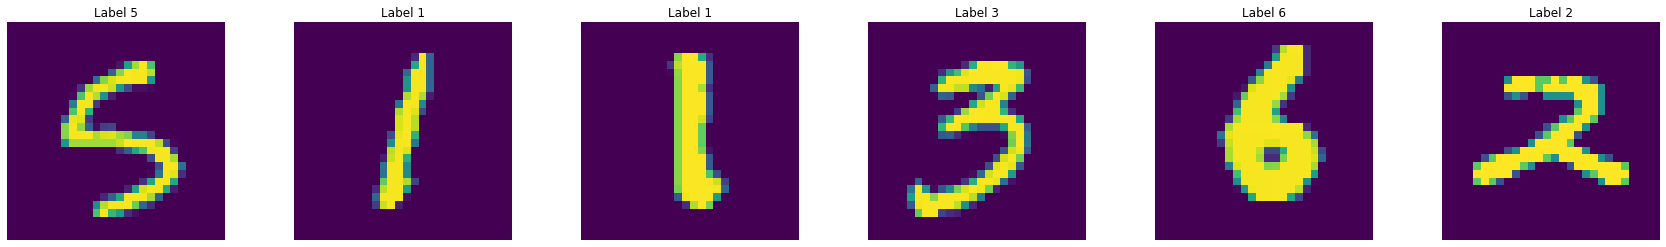

In [7]:
display_subset_data(imgs=train_imgs, labels=train_labels)

# 2. Feature Extraction

In this section, we perform the feature extraction steps of the POC algorithm. Namely, we extract the class prototypes and the eigenvectors of each class.

In [8]:
cluster_ids = np.arange(10).tolist()

# extracting features for the data in the pixel domain
img_classwise_data, img_prototypes,\
    img_eigenvectors = get_features_all_classes(data=train_imgs, labels=train_labels, verbose=1,
                                                cluster_ids=cluster_ids, standarize=False)

# extracting features for the scattering in the pixel domain
scat_classwise_data, scat_prototypes,\
    scat_eigenvectors = get_features_all_classes(data=train_scat_features, labels=train_labels, verbose=1,
                                                 cluster_ids=cluster_ids, standarize=False)

100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


# 3. Image Classification

In this third section we focus on the image classification task

## 3.1 Parameter Optimization

First, we use the validation set to optimize the model parameters, i.e., the number of directions to remove.

In [9]:
direction_candidates = np.arange(0, MAX_DIMS, STEP)

### Optimizing for the image domain

In [10]:
opt_dims_img, max_acc_img,\
    accuracies_img = optimize_dimensionality(data=valid_imgs, labels=valid_labels,
                                             dims=direction_candidates, 
                                             prototypes=img_prototypes,
                                             eigenvectors=img_eigenvectors,
                                             verbose=1)

100%|██████████| 30/30 [01:10<00:00,  2.34s/it]

Maximum accuracy was 96.15. It was found removing 30 directions.


In [11]:
min_dims = max(0, opt_dims_img - 10)
max_dims = min(MAX_DIMS, opt_dims_img + 11)
fine_direction_candidates = np.arange(min_dims, max_dims)

fine_opt_dims_img, fine_max_acc_img,\
    fine_accuracies_img = optimize_dimensionality(data=valid_imgs, labels=valid_labels,
                                                  dims=fine_direction_candidates, 
                                                  prototypes=img_prototypes,
                                                  eigenvectors=img_eigenvectors, verbose=1)

100%|██████████| 21/21 [00:47<00:00,  2.26s/it]

Maximum accuracy was 96.27. It was found removing 27 directions.


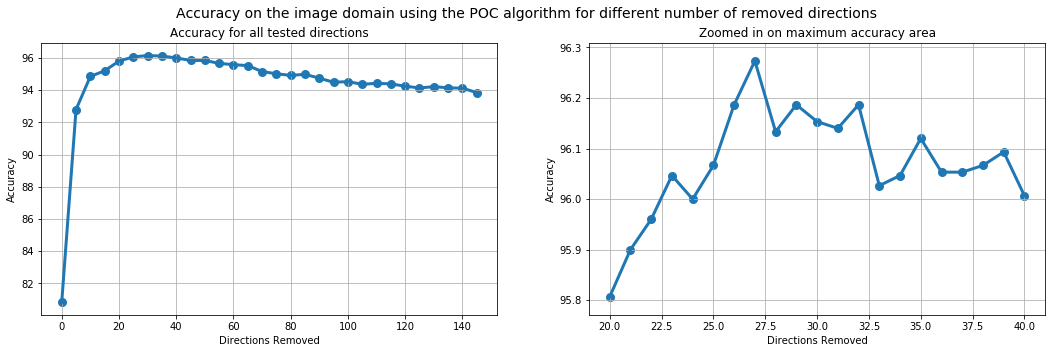

In [12]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18,5)
fig.suptitle("Accuracy on the image domain using the POC algorithm for different number of removed directions", fontsize=14)
visualize_accuracy_landscape(xaxis=direction_candidates, accuracy=accuracies_img, 
                             ax=ax[0], xlabel="Directions Removed", ylabel="Accuracy",
                             title="Accuracy for all tested directions", grid=True)
visualize_accuracy_landscape(xaxis=fine_direction_candidates, accuracy=fine_accuracies_img, 
                             ax=ax[1], xlabel="Directions Removed", ylabel="Accuracy",
                             title="Zoomed in on maximum accuracy area", grid=True)

### Optimizing for the scattering domain

In [13]:
opt_dims_scat, max_acc_scat,\
    accuracies_scat = optimize_dimensionality(data=valid_scat_features, labels=valid_labels,
                                             dims=direction_candidates, 
                                             prototypes=scat_prototypes,
                                             eigenvectors=scat_eigenvectors,
                                             verbose=1)

100%|██████████| 30/30 [04:15<00:00,  8.52s/it]

Maximum accuracy was 99.79. It was found removing 145 directions.


In [14]:
min_dims = max(0, opt_dims_scat - 10)
max_dims = min(MAX_DIMS, opt_dims_scat + 11)
fine_direction_candidates = np.arange(min_dims, max_dims)

fine_opt_dims_scat, fine_max_acc_scat,\
    fine_accuracies_scat = optimize_dimensionality(data=valid_scat_features, labels=valid_labels,
                                                   dims=fine_direction_candidates, 
                                                   prototypes=scat_prototypes,
                                                   eigenvectors=scat_eigenvectors,
                                                   verbose=1)

100%|██████████| 15/15 [02:08<00:00,  8.55s/it]

Maximum accuracy was 99.79. It was found removing 144 directions.


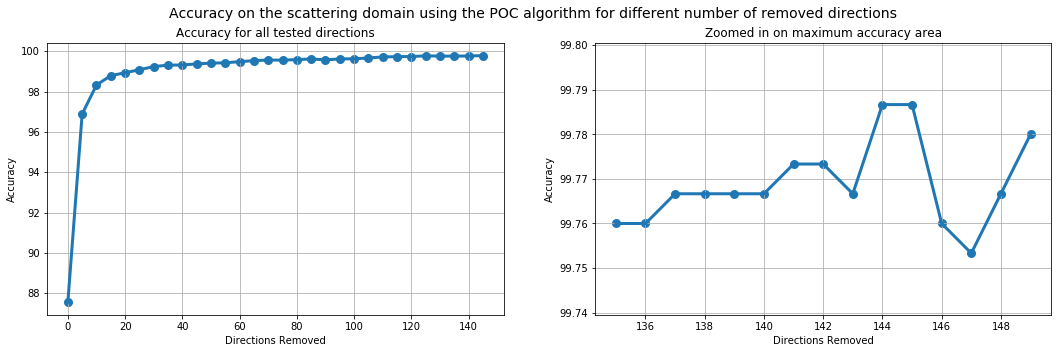

In [15]:
fig, ax = plt.subplots(1, 2)
fig.set_size_inches(18,5)
fig.suptitle("Accuracy on the scattering domain using the POC algorithm for different number of removed directions", fontsize=14)
visualize_accuracy_landscape(xaxis=direction_candidates, accuracy=accuracies_scat, 
                             ax=ax[0], xlabel="Directions Removed", ylabel="Accuracy",
                             title="Accuracy for all tested directions", grid=True)
visualize_accuracy_landscape(xaxis=fine_direction_candidates, accuracy=fine_accuracies_scat, 
                             ax=ax[1], xlabel="Directions Removed", ylabel="Accuracy",
                             title="Zoomed in on maximum accuracy area", grid=True)

## 3.2 Test Set Evaluation

We now use the features extracted from the training set and the parameters optimized on the validation set to classify the images from the test split.

In [16]:
pred_test_labels_img, _ = projections_classifier(points=test_imgs,
                                                 prototypes=img_prototypes,
                                                 eigenvectors=img_eigenvectors,
                                                 n_directions=fine_opt_dims_img)

n_correct_labels_img = len(np.where(pred_test_labels_img == test_labels.numpy())[0])
test_set_acc_img = 100 * n_correct_labels_img / len(test_labels)

In [17]:
pred_test_labels_scat, _ = projections_classifier(points=test_scat_features,
                                                  prototypes=scat_prototypes,
                                                  eigenvectors=scat_eigenvectors,
                                                  n_directions=fine_opt_dims_scat)

n_correct_labels_scat = len(np.where(pred_test_labels_scat == test_labels.numpy())[0])
test_set_acc_scat = 100 * n_correct_labels_scat / len(test_labels)

In [20]:
print(f"Test set accuracy results:")
print(f"    Img Domain:  {round(test_set_acc_img, 3)}%")
print(f"    Scat Domain: {round(test_set_acc_scat, 3)}%")

Test set accuracy results:
    Img Domain:  96.01%
    Scat Domain: 99.2%


<div class=alert style="background-color:#F5F5F5; border-color:#C8C8C8">
   This notebook was created by <b>Angel Villar-Corrales</b>
</div> 